In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u
from astropy.wcs import WCS
from astropy.coordinates import SkyCoord
from astropy.table import Table
import regions
from regions import Regions

In [2]:
%cd ..
from jwst_plots import JWSTCatalog
from jwst_plots import make_cat_use
import cutout_manager as cm
%cd notebooks/

/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament
/blue/adamginsburg/savannahgramze/cloudc/lactea-filament/lactea-filament/notebooks


In [3]:
basepath = '/orange/adamginsburg/jwst/cloudc/'

# Load Catalog

In [4]:
fn_405 = f'{basepath}/images/jw02221-o002_t001_nircam_clear-f405n-merged-nodestreak_i2d-perfilt64.fits'
ww = WCS(fits.open(fn_405)[0].header)

In [5]:
cat_use = make_cat_use()

In [6]:
#cat_use.catalog.write('/orange/adamginsburg/jwst/cloudc/catalogs/jwst_cloudc_catalog.fits')

In [7]:
pos = SkyCoord('17:46:20.6290029866', '-28:37:49.5114204513', unit=(u.hour, u.deg))
l = 113.8*u.arcsec
w = 3.3*u.arcmin
reg = regions.RectangleSkyRegion(pos, width=l, height=w)
#Regions.read('/orange/adamginsburg/jwst/cloudc/regions_/filament_box.region')

In [8]:
cutout_405 = cm.get_cutout_405(pos, w, l)
ww = cutout_405.wcs
data = cutout_405.data

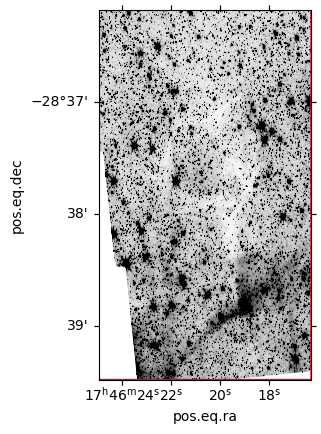

In [9]:
ax = plt.subplot(projection=cutout_405.wcs)
ax.imshow(cutout_405.data, cmap='Greys', vmin=0, vmax=50)
reg.to_pixel(cutout_405.wcs).plot(ax=ax, edgecolor='r', facecolor='none')

In [10]:
cat_filament = JWSTCatalog(cat_use.table_region_mask([reg], ww))

In [11]:
mask_187 = np.logical_and(cat_filament.catalog['mag_ab_f187n'] < 15, cat_filament.color('F187N', 'F182M') < -0.3)
mask = np.logical_or(~mask_187, np.isnan(np.array(cat_filament.catalog['mag_ab_f187n'])))
#mask &= cat_filament.catalog['mag_ab_f182m'] > 15 | np.isnan(np.array(cat_filament.catalog['mag_ab_f182m']))
#mask &= cat_filament.catalog['mag_ab_f212n'] > 15 | np.isnan(np.array(cat_filament.catalog['mag_ab_f212n']))
mask_405 = np.logical_and(cat_filament.catalog['mag_ab_f405n'] < 13.5, cat_filament.color('F405N', 'F410M') < -0.3)
mask &= np.logical_or(~mask_405, np.isnan(np.array(cat_filament.catalog['mag_ab_f405n'])))
#mask &= np.logical_or(cat_filament.catalog['mag_ab_f466n'] > 13.5, np.isnan(cat_filament.catalog['mag_ab_f466n']))
#mask &= np.logical_or(cat_filament.catalog['mag_ab_f405n'] > 13.5, np.isnan(cat_filament.catalog['mag_ab_f405n']))

cat_filament_m = JWSTCatalog(cat_filament.catalog[mask])

In [14]:
from dust_extinction.averages import CT06_MWLoc

def plot_extinction_vector(band1, band2, band3, band4, ax=None, ext=CT06_MWLoc(), scale=200, start=(0,0), color='k', head_width=0.1, **kwargs):
    if ax is None:
        ax = plt.gca()
    w1 = int(band1[1:-1])/100*u.um
    w2 = int(band2[1:-1])/100*u.um
    w3 = int(band3[1:-1])/100*u.um
    w4 = int(band4[1:-1])/100*u.um
    e_1 = ext(w1) * scale
    e_2 = ext(w2) * scale
    e_3 = ext(w3) * scale
    e_4 = ext(w4) * scale
    #ax.arrow(start[0], start[1], e_1-e_2, e_3-e_4, color=color, head_width=head_width, label=f'$A_V={scale}$', **kwargs)
    ax.annotate("", xytext=start, xy=(start[0] + e_1 - e_2, start[1] + e_3 - e_4),
                arrowprops=dict(arrowstyle="->", color=color, lw=2, **kwargs),
                label=f'$A_V={scale}$')

(0.0, 3.5)

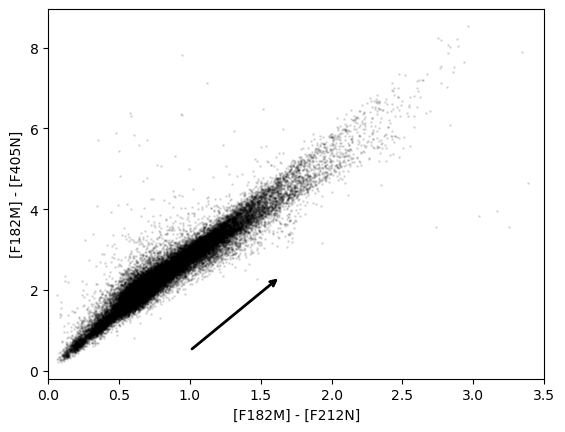

In [15]:
ax = plt.subplot(111)
cat_use.plot_CCD('f182m', 'f212n', 'f182m', 'f405n', ax=ax, color='k', s=1, alpha=0.1)
plot_extinction_vector('F182M', 'F212N', 'F182M', 'F405N', ax=ax, color='k', scale=20, start=(1, 0.5))

ax.set_xlim(0, 3.5)

In [16]:
print(len(cat_filament_m.catalog), len(cat_filament.catalog))

37344 37344


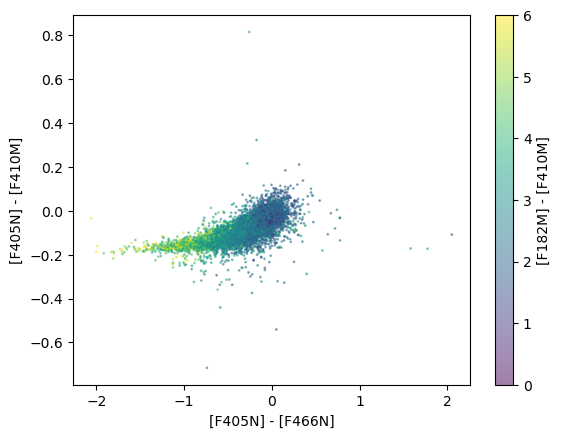

In [17]:
ax = plt.subplot(111)
im = cat_filament.plot_CCD('f405n', 'f466n', 'f405n', 'f410m', c=cat_filament.color('f182m', 'f410m'), s=1, alpha=0.5, ax=ax, vmin=0, vmax=6)
#ax.set_ylim(-1, 1)
#ax.set_xlim(0, 3)
plt.colorbar(im, ax=ax, label='[F182M] - [F410M]')

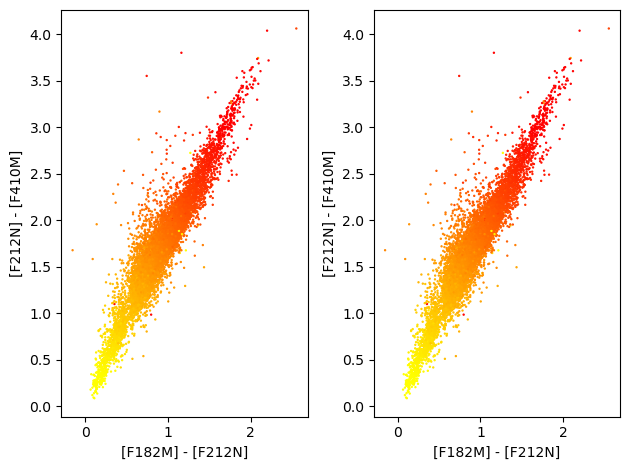

In [18]:
ax1 = plt.subplot(121)
cat_filament.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=cat_filament.color('F187N', 'F405N'), 
                 ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)

ax2 = plt.subplot(122)
cat_filament_m.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=cat_filament_m.color('F187N', 'F405N'), 
                   ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)

plt.tight_layout()

# Prep Colors

In [19]:
color_187_405 = cat_filament.color('F187N', 'F405N')
color_182_212 = cat_filament.color('F182M', 'F212N')
color_212_410 = cat_filament.color('F212N', 'F410M')
color_410_466 = cat_filament.color('F410M', 'F466N')
color_405_410 = cat_filament.color('F405N', 'F410M')
color_187_182 = cat_filament.color('F187N', 'F182M')
color_182_410 = cat_filament.color('F182M', 'F410M')

In [20]:
data_0 = np.zeros_like(cutout_405.data)
data_0[data_0 == 0] = np.nan

## Plots

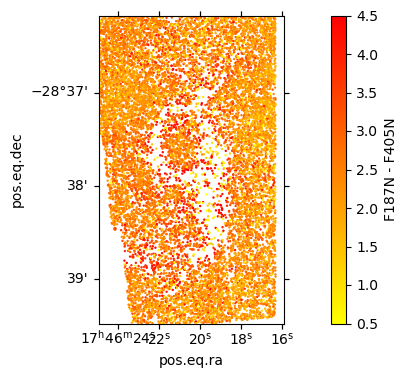

In [21]:
fig = plt.figure(figsize=(12, 4))
ax = plt.subplot(111, projection=ww)
ax.imshow(data_0, cmap='gray', origin='lower')
im = ax.scatter(cat_filament.ra, cat_filament.dec, c=color_187_405, s=0.5, cmap='autumn_r', transform=ax.get_transform('world'), vmin=0.5, vmax=4.5)
plt.colorbar(im, label='F187N - F405N')
plt.show()

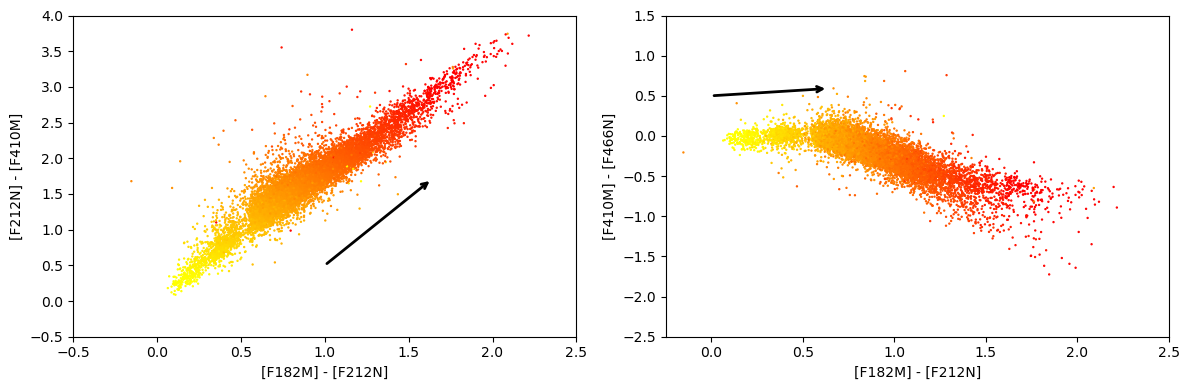

In [22]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(121)
cat_filament.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=color_187_405, ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
plot_extinction_vector('F182M', 'F212N', 'F212N', 'F410M', ax=ax1, color='k', scale=20, start=(1, 0.5), head_width=0.1)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 4)

ax2 = plt.subplot(122)
cat_filament.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=color_187_405, ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
plot_extinction_vector('F182M', 'F212N', 'F410M', 'F466N', ax=ax2, color='k', scale=20, start=(0, 0.5), head_width=0.1)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.axvline(0.55, color='k', linestyle='--')

plt.tight_layout()
plt.show()

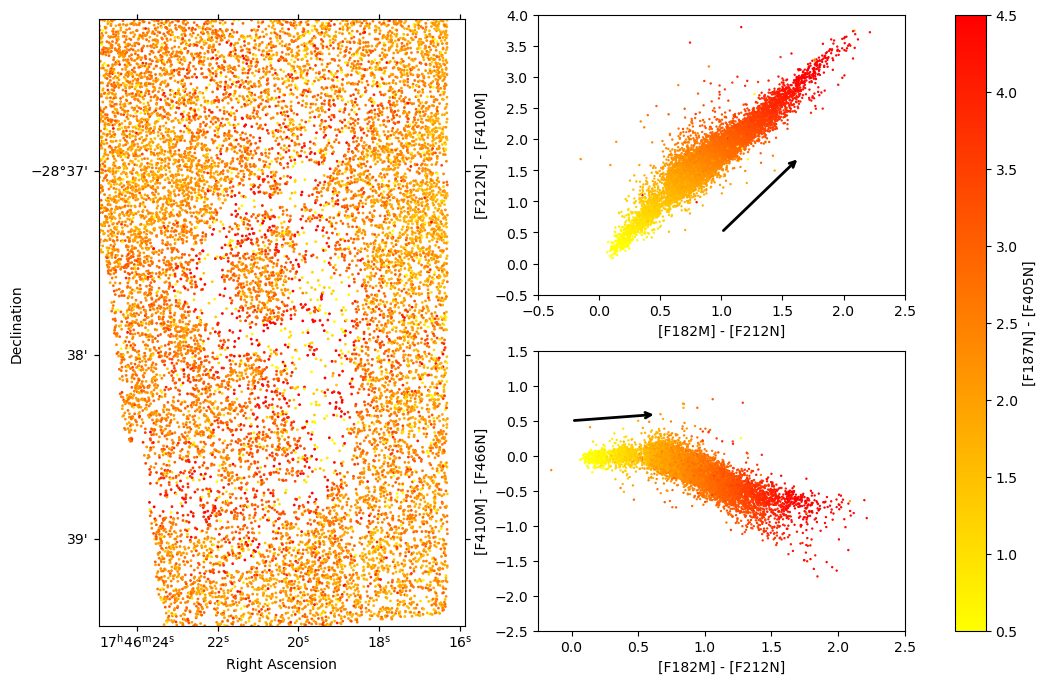

In [23]:
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(121, projection=ww)
ax.imshow(data_0, cmap='gray', origin='lower')
im = ax.scatter(cat_filament.ra, cat_filament.dec, c=color_187_405, s=1, cmap='autumn_r', transform=ax.get_transform('world'), vmin=0.5, vmax=4.5)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax1 = fig.add_subplot(222)
cat_filament.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=color_187_405, ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
plot_extinction_vector('F182M', 'F212N', 'F212N', 'F410M', ax=ax1, color='k', scale=20, start=(1, 0.5), head_width=0.1)

ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 4)

ax2 = fig.add_subplot(224)
cat_filament.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=color_187_405, ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
plot_extinction_vector('F182M', 'F212N', 'F410M', 'F466N', ax=ax2, color='k', scale=20, start=(0, 0.5), head_width=0.1)

ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)

plt.colorbar(im, label='[F187N] - [F405N]', ax=[ax, ax1, ax2])
#plt.tight_layout()

plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_CCDs.png', dpi=300, bbox_inches='tight')
plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_CCDs.pdf', bbox_inches='tight')

plt.show()

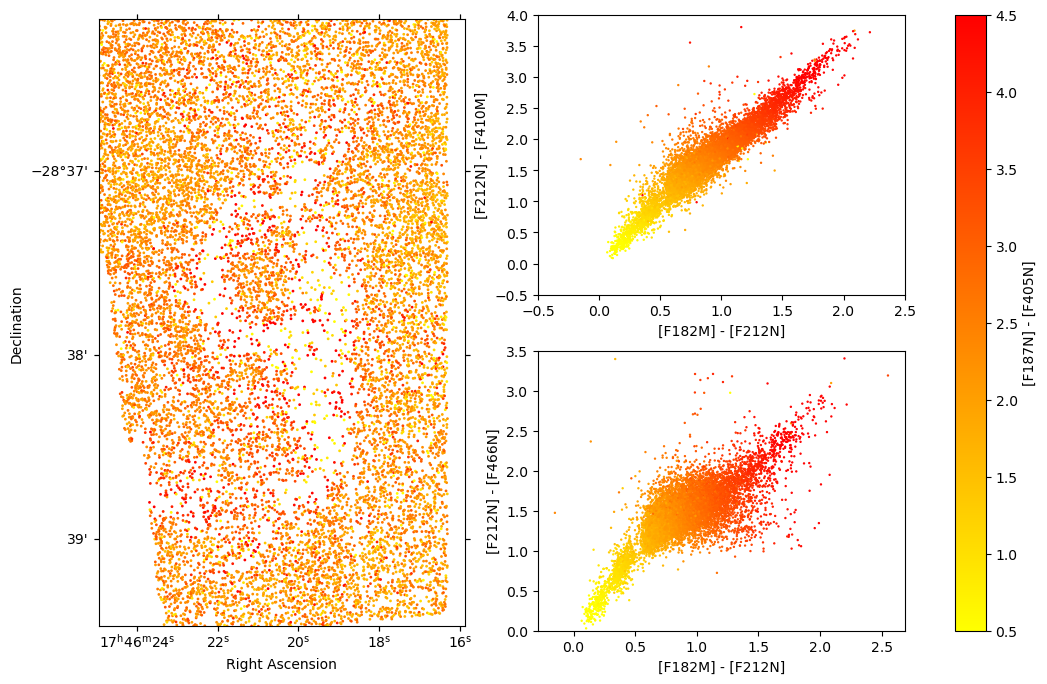

In [23]:
fig = plt.figure(figsize=(13, 8))

ax = fig.add_subplot(121, projection=ww)
ax.imshow(data_0, cmap='gray', origin='lower')
im = ax.scatter(cat_filament.ra, cat_filament.dec, c=color_187_405, s=1, cmap='autumn_r', transform=ax.get_transform('world'), vmin=0.5, vmax=4.5)
ax.set_xlabel('Right Ascension')
ax.set_ylabel('Declination')

ax1 = fig.add_subplot(222)
cat_filament.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=color_187_405, ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 4)

ax2 = fig.add_subplot(224)
cat_filament.plot_CCD('F182M', 'F212N', 'F212N', 'F466N', c=color_187_405, ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
#ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(0, 3.5)

plt.colorbar(im, label='[F187N] - [F405N]', ax=[ax, ax1, ax2])
#plt.tight_layout()

#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_CCDs.png', dpi=300, bbox_inches='tight')
#plt.savefig('/orange/adamginsburg/jwst/cloudc/figures/filament_CCDs.pdf', bbox_inches='tight')

plt.show()

# Linear Fit to A_CO

In [118]:
mask_187 = np.logical_and(cat_filament.catalog['mag_ab_f187n'] < 15, cat_filament.color('F187N', 'F182M') < -0.3)
mask = np.logical_or(~mask_187, np.isnan(np.array(cat_filament.catalog['mag_ab_f187n'])))
mask_405 = np.logical_and(cat_filament.catalog['mag_ab_f405n'] < 13.5, cat_filament.color('F405N', 'F410M') < -0.3)
mask &= np.logical_or(~mask_405, np.isnan(np.array(cat_filament.catalog['mag_ab_f405n'])))

mask_m = np.logical_and(mask, cat_filament.color('f182m', 'f212n') > 0.55)

In [125]:
np.sum(mask_m), np.sum(mask)

(11231, 12624)

In [119]:
cat_masked = JWSTCatalog(cat_filament.apply_mask(mask_m))

In [120]:
color_masked_187_405 = cat_masked.color('F187N', 'F405N')
color_masked_182_212 = cat_masked.color('F182M', 'F212N')
color_masked_212_410 = cat_masked.color('F212N', 'F410M')
color_masked_410_466 = cat_masked.color('F410M', 'F466N')
color_masked_405_410 = cat_masked.color('F405N', 'F410M')
color_masked_187_182 = cat_masked.color('F187N', 'F182M')
color_masked_182_410 = cat_masked.color('F182M', 'F410M')

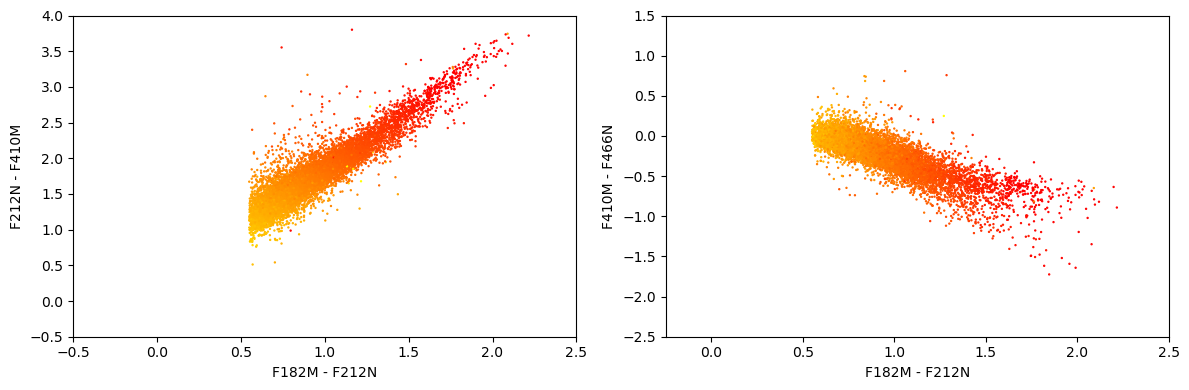

In [121]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(121)
cat_masked.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=color_masked_187_405, ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 4)

ax2 = plt.subplot(122)
cat_masked.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=color_masked_187_405, ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.axvline(0.55, color='k', linestyle='--')

plt.tight_layout()
plt.show()

In [122]:
from astropy.modeling import models, fitting


In [123]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter()
best_fit_Aco = fitter(model, color_masked_182_212, color_masked_410_466)
print(best_fit_Aco)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
            slope              intercept      
    --------------------- --------------------
    -0.005799905832478688 -0.23499786419839733


In [116]:
model = models.Linear1D()
fitter = fitting.LinearLSQFitter()
best_fit_Av = fitter(model, color_masked_182_212, color_masked_212_410)
print(best_fit_Av)

Model: Linear1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          slope            intercept     
    ------------------ ------------------
    1.0776175618076864 0.7435852800662935


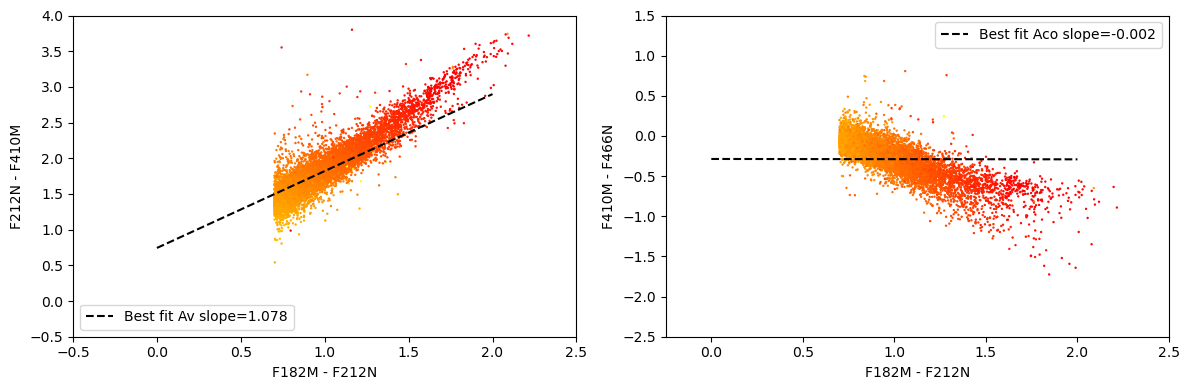

In [117]:
fig = plt.figure(figsize=(12, 4))

ax1 = plt.subplot(121)
cat_masked.plot_CCD('F182M', 'F212N', 'F212N', 'F410M', c=color_masked_187_405, ax=ax1, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax1.set_xlim(-0.5, 2.5)
ax1.set_ylim(-0.5, 4)
ax1.plot([0, 2], best_fit_Av([0, 2]), color='k', linestyle='--', label=f'Best fit Av slope={round(best_fit_Av.slope.value, 3)}')
ax1.legend()

ax2 = plt.subplot(122)
cat_masked.plot_CCD('F182M', 'F212N', 'F410M', 'F466N', c=color_masked_187_405, ax=ax2, s=0.5, cmap='autumn_r', vmin=0.5, vmax=4.5)
ax2.set_xlim(-0.25, 2.5)
ax2.set_ylim(-2.5, 1.5)
#ax2.axvline(0.55, color='k', linestyle='--')
ax2.plot([0, 2], best_fit_Aco([0, 2]), color='k', linestyle='--', label=f'Best fit Aco slope={round(best_fit_Aco.slope.value, 3)}')
ax2.legend()

plt.tight_layout()
plt.show()

In [122]:
best_fit_Aco.slope, best_fit_Aco.intercept

(Parameter('slope', value=-0.7476528179808736),
 Parameter('intercept', value=0.49814938541559844))

In [124]:
print(best_fit_Aco.slope.value)

-0.7476528179808736


In [125]:
print(best_fit_Av.slope.value)

1.51077950027034


In [130]:
cat_masked.catalog.columns

<TableColumns names=('skycoord_ref','skycoord_ref_filtername','sep_f410m','id_f410m','skycoord_f410m','flux_f410m','flux_err_f410m','mask_f410m','qfit_f410m','cfit_f410m','flux_init_f410m','flags_f410m','local_bkg_f410m','group_size_f410m','dra_f410m','ddec_f410m','std_ra_f410m','std_dec_f410m','nmatch_f410m','nmatch_good_f410m','flux_err_prop_f410m','flux_jy_f410m','mag_ab_f410m','eflux_jy_f410m','emag_ab_f410m','near_saturated_f410m_f410m','replaced_saturated_f410m','sep_f212n','id_f212n','skycoord_f212n','flux_f212n','flux_err_f212n','mask_f212n','qfit_f212n','cfit_f212n','flux_init_f212n','flags_f212n','local_bkg_f212n','group_size_f212n','dra_f212n','ddec_f212n','std_ra_f212n','std_dec_f212n','nmatch_f212n','nmatch_good_f212n','flux_err_prop_f212n','flux_jy_f212n','mag_ab_f212n','eflux_jy_f212n','emag_ab_f212n','near_saturated_f212n_f212n','replaced_saturated_f212n','sep_f466n','id_f466n','skycoord_f466n','flux_f466n','flux_err_f466n','mask_f466n','qfit_f466n','cfit_f466n','flux_i